In [1]:
from plotting import user_rc
run apogee_lcs.py 5285607

/Users/diana/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Isodata.cat already exists; loaded.
LC data for KIC 5285607 loaded.
Excluding  []
Clip tolerance = 1.5


In [2]:
prefix='kics/{0}/'.format(kic)
check_dir_exists(prefix)

Directory already exists.


In [70]:
msum, rsum, rrat, b, frat = lcpars_guess_init(keblat.phase[keblat.clip], 
                                          keblat.flux[keblat.clip], period, keblat.sep,
                                        keblat.swidth, keblat.pwidth, sdep, pdep)
#ew_trials = [[esinw, ecosw], [-esinw, ecosw], [-0.521, ecosw], [-0.332, ecosw], [-0.142, ecosw], [0.521, ecosw], [0.332, ecosw], [0.142, ecosw]]
#lcpars0 = np.array([msum, rsum, rrat, period, tpe, esinw, ecosw, b, frat, q1, q2, q3, q4])
#ew = ew_search_lmfit(ew_trials, lcpars0, (period, tpe, tpe+keblat.sep*period), fit_ecosw=False, polyorder=1)

b_trials = [0.1, 0.4, 0.8]
rrat_trials = [0.3, 0.5, 0.95]


#b_trials = [b] + [float(jj) for jj in np.array(b_trials)[~np.in1d(b_trials, b)]]
#rrat_trials = [rrat] + [float(jj) for jj in np.array(rrat_trials)[~np.in1d(rrat_trials, rrat)]]
lc_search_counts=0
bestlcchi2 = 1e25
ew = [esinw, ecosw]

In [71]:
print msum, rsum, rrat, b, frat, esinw, ecosw, ew
keblat.parbounds['b'][1] = 7.0
keblat.parbounds['mrat'] = [0.0085, 10.]
keblat.updatebounds('period', 'tpe')
if ecosw<0.01:
    keblat.updatebounds('ecosw')
if esinw<0.01:
    keblat.parbounds['ecosw'] = [-0.1, 0.1]
keblat.parbounds['rrat'] = [1e-5, 1.0]
print keblat.parbounds

1.36400267306 1.55809227178 [ 0.95] 0.1 [ 0.87964819] 0.0629183400268 -0.000942477796077 [0.062918340026773684, -0.00094247779607692134]
OrderedDict([('m1', [0.1, 12.0]), ('m2', [0.1, 12.0]), ('z0', [0.001, 0.06]), ('age', [6.0, 10.1]), ('dist', [10.0, 15000.0]), ('ebv', [0.0, 1.0]), ('h0', [118.0, 120.0]), ('period', [3.8214130812308453, 3.9773891253627167]), ('tpe', [124.04612992378273, 129.10923726761058]), ('esinw', [-0.99, 0.99]), ('ecosw', [0.0001266346710499533, 0.00013180343313362486]), ('b', [0.0, 7.0]), ('q1', [0.0, 1.0]), ('q2', [0.0, 1.0]), ('q3', [0.0, 1.0]), ('q4', [0.0, 1.0]), ('lcerr', [0.0, 0.01]), ('isoerr', [0.0, 0.3]), ('k0', [-39212.260000000002, 161694.81]), ('rverr', [0.0, 10000.0]), ('msum', [0.2, 24.0]), ('mrat', [0.0085, 10.0]), ('rsum', [0.1, 1000000.0]), ('rrat', [1e-05, 1.0]), ('r1', [0.01, 1000000.0]), ('r2', [0.01, 1000000.0]), ('inc', [0.0, 1.5707963267948966]), ('frat', [1e-08, 100.0])])


In [72]:
###################################################################################
########################### LC ONLY OPTIMIZATION FIRST ############################
###################################################################################

# for i_b, i_rrat, i_ew in list(itertools.product(b_trials, rrat_trials, ew_trials)):
for i_b, i_rrat in list(itertools.product(b_trials, rrat_trials)):
    # lcpars0 = np.array([rsum, rsum, i_rrat, period, tpe, ew[0], ew[1], i_b, i_rrat**(2.5),
    #                     q1, q2, q3, q4])
    upper_b = 2.*i_b if i_b==0.01 else 3.0
    keblat.parbounds['b'][1] = upper_b
    opt_lcpars0 = opt_lc(msum=rsum, rsum=rsum, rrat=i_rrat, period=period, tpe=tpe, esinw=ew[0],
                         ecosw=ew[1], b=i_b, frat=i_rrat**2.5, q1=q1, q2=q2, q3=q3, q4=q4)

    lcchi2 = np.sum(rez(opt_lcpars0, polyorder=2)**2)/(np.sum(keblat.clip) - len(opt_lcpars0) - 1)
    if (lcchi2 < bestlcchi2) or (lc_search_counts < 1):
        print "Saving from this run:", lcchi2, bestlcchi2, lc_search_counts
        bestlcchi2 = lcchi2*1.0
        opt_lcpars = opt_lcpars0
    lc_search_counts+=1

    if (bestlcchi2 <= 1.5) and opt_lcpars[2]<=1.0:
        print "These init b, rrat, esinw, ecosw lcpars are: ", i_b, i_rrat, ew
        break

==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 672
    # data points      = 15898
    # variables        = 7
    chi-square         = 390685.495
    reduced chi-square = 24.585
    Akaike info crit   = 50914.779
    Bayesian info crit = 50968.496
[[Variables]]
    q1:       0.01 (fixed)
    q2:       0.01 (fixed)
    tpe:      126.577522 +/- 0        (0.00%) (init= 126.576)
    b:        1.51142067 +/- 0        (0.00%) (init= 0.1)
    ecosw:    0.00012663 +/- 0        (0.00%) (init= 0.0001266347)
    q4:       0.01 (fixed)
    rsum:     3.00200008 +/- 0        (0.00%) (init= 1.558092)
    period:   3.899401 (fixed)
    q3:       0.01 (fixed)
    msum:     1.558092 (fixed)
    frat:     0.63766982 +/- 0        (0.00%) (init= 0.04929503)
    rrat:     0.81153582 +/- 0        (0.00%) (init= 0.3)
    esinw:    0.00201509 +/- 0        (0.00%) (init= 0.06291834)
[[Correlations]] (unreported correlations are <  0.100)
pol

In [73]:
print opt_lcpars, keblat.pars

[  1.69622946e+00   3.05848688e+00   7.98174276e-01   3.89940110e+00
   1.26577504e+02   2.59208748e-03   1.26634671e-04   1.48010372e+00
   6.14501938e-01   3.24914544e-01   1.15075286e-01   2.66990419e-01
   3.64543180e-01] OrderedDict([('m1', None), ('m2', None), ('z0', None), ('age', None), ('dist', None), ('ebv', None), ('h0', None), ('period', 3.8994011), ('tpe', 126.57621262140323), ('esinw', -0.17877178829682228), ('ecosw', 0.0001266346710499533), ('b', 1.8137580546253258), ('q1', 0.01), ('q2', 0.01), ('q3', 0.01), ('q4', 0.01), ('lcerr', None), ('isoerr', None), ('k0', None), ('rverr', None), ('msum', 1.5580922717833185), ('mrat', None), ('rsum', 0.58217203359990344), ('rrat', 5.2474007842654937e-05), ('r1', 0.58214148630298557), ('r2', 3.0547296917797672e-05), ('inc', 1.4833541037782414), ('frat', 1.4953189106869136)])


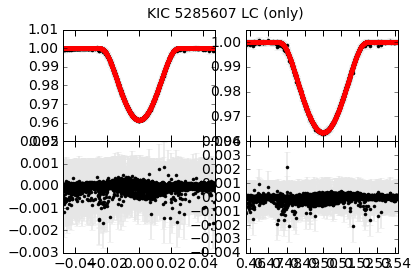

In [74]:
#opt_lcpars = np.loadtxt('kics/5285607/lcpars2.lmfit')
try:
    make_lc_plots(kic, opt_lcpars, prefix, polyorder=2, suffix='lc_opt2', savefig=True)
except Exception, e:
    print str(e)


#if bestlcchi2 < lcchi2_threshold:
#    print "Saving lmfit lcpars..."
#    np.savetxt(prefix+'lcpars.lmfit', opt_lcpars)

In [75]:
t, rv1, rv1err, rv2, rv2err = np.loadtxt('data/5285607_jm.rv.txt', usecols=(2, 3, 4, 5, 6), unpack=True)

In [76]:
m1, m2, k0 = keblat.rvprep(t, rv1*1e3, rv2*1e3, rv1err*1e3, rv2err*1e3)

In [77]:
phase = (t-keblat.pars['tpe'])%keblat.pars['period']/keblat.pars['period']

Populating the interactive namespace from numpy and matplotlib


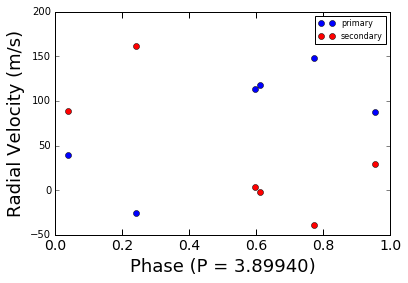

In [78]:
%pylab inline
plt.plot(phase, rv1, 'bo', label='primary')
plt.plot(phase, rv2, 'ro', label='secondary')
plt.xlabel('Phase (P = {0:.5f})'.format(keblat.pars['period']))
plt.ylabel('Radial Velocity (m/s)')
plt.legend(fontsize=8)
plt.show()

In [79]:
keblat.updatepars(m1=m1, m2=m2, msum=m1+m2, mrat=m2/m1)
keblat.updatebounds('period', 'tpe', 'msum', 'mrat')
rvpars = [m1+m2, m2/m1, opt_lcpars[3], opt_lcpars[4], opt_lcpars[5], opt_lcpars[6], keblat.pars['inc'], k0, 0]
opt_rvpars = opt_rv(msum=m1+m2, mrat=m2/m1, period=opt_lcpars[3], tpe=opt_lcpars[4], esinw=opt_lcpars[5],
                       ecosw=opt_lcpars[6], inc=keblat.pars['inc'], k0=k0, rverr=0)

rverr 0
tpe 126.577504212
ecosw 0.00012663467105
mrat 0.861929050083
period 3.8994011
msum 2.64112629116
k0 63928.32
esinw 0.00259208748299
inc 1.36697924017
========================= Starting RV ONLY fit... ========================
Parameters([('rverr', <Parameter 'rverr', value=0 (fixed), bounds=[0.0:10000.0]>), ('tpe', <Parameter 'tpe', value=126.57750421214521 (fixed), bounds=[124.04595412790231:129.10905429638811]>), ('ecosw', <Parameter 'ecosw', 0.0001266346710499533, bounds=[0.0001266346710499533:0.00013180343313362486]>), ('mrat', <Parameter 'mrat', 0.86192905008270759, bounds=[0.8446904690810535:0.87916763108436169]>), ('period', <Parameter 'period', value=3.8994011 (fixed), bounds=[3.821413078:3.9773891219999999]>), ('msum', <Parameter 'msum', 2.6411262911576538, bounds=[2.5883037653345009:2.6939488169808068]>), ('k0', <Parameter 'k0', 63928.32, bounds=[-39212.260000000002:161694.81]>), ('esinw', <Parameter 'esinw', 0.0025920874829863383, bounds=[-0.99:0.99]>), ('inc', <Param

True

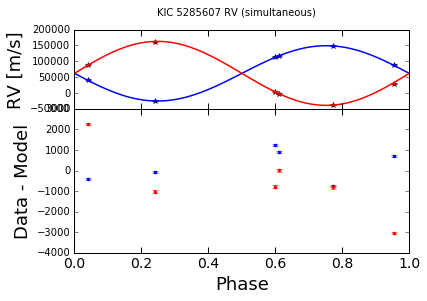

In [81]:
keblat.plot_rv(opt_rvpars, prefix, savefig=False)

In [109]:
opt_lcpars[0] = opt_rvpars[0]
lcpars2 = opt_lc(msum=m1+m2, rsum=opt_lcpars[1], rrat=opt_lcpars[2], period=opt_lcpars[3], tpe=opt_lcpars[4],
                 esinw=0.02, ecosw=opt_lcpars[6], b=opt_lcpars[7], frat=opt_lcpars[8], q1=opt_lcpars[9],
                 q2=opt_lcpars[10], q3=opt_lcpars[11], q4=opt_lcpars[12], vary_msum=False)

==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 178
    # data points      = 15902
    # variables        = 7
    chi-square         = 312674.184
    reduced chi-square = 19.671
    Akaike info crit   = 47381.555
    Bayesian info crit = 47435.274
[[Variables]]
    q1:       0.3249145 (fixed)
    q2:       0.1150753 (fixed)
    tpe:      126.577504 +/- 0        (0.00%) (init= 126.5775)
    b:        1.36786984 +/- 0        (0.00%) (init= 1.480104)
    ecosw:    0.00012663 +/- 0        (0.00%) (init= 0.0001266347)
    q4:       0.3645432 (fixed)
    rsum:     3.52171354 +/- 0        (0.00%) (init= 3.058487)
    period:   3.899401 (fixed)
    q3:       0.2669904 (fixed)
    msum:     2.641126 (fixed)
    frat:     0.43689427 +/- 0        (0.00%) (init= 0.6145019)
    rrat:     0.67344902 +/- 0        (0.00%) (init= 0.7981743)
    esinw:    0.00436755 +/- 0        (0.00%) (init= 0.02)
[[Correlations]] (unreported corre

In [97]:
keblat.parbounds['mrat'] = [0.8, 0.9]
keblat.parbounds['msum'] = [2.5, 2.8]

In [110]:
opt_lcrvpars = opt_lcrv(msum=opt_rvpars[0], mrat=opt_rvpars[1],
                        rsum=lcpars2[1], rrat=lcpars2[2], period=lcpars2[3],
                        tpe=lcpars2[4], esinw=lcpars2[5], ecosw=lcpars2[6],
                        b=lcpars2[7], frat=lcpars2[8], q1=lcpars2[-4],
                        q2=lcpars2[-3], q3=lcpars2[-2], q4=lcpars2[-1],
                        lcerr=0.0, k0=opt_rvpars[-2], rverr=0.)

================= Starting LC + RV simultaneous fit... ===================
14.8440232568 14.8598423502
[[Fit Statistics]]
    # function evals   = 264
    # data points      = 15914
    # variables        = 17
    chi-square         = 236226.914
    reduced chi-square = 14.860
    Akaike info crit   = 42963.505
    Bayesian info crit = 43093.979
[[Variables]]
    q1:       0.40229991 +/- 0        (0.00%) (init= 0.4849856)
    q2:       0.00080995 +/- 0        (0.00%) (init= 0.00133079)
    tpe:      126.577504 +/- 0        (0.00%) (init= 126.5775)
    b:        1.37006579 +/- 0        (0.00%) (init= 1.369891)
    ecosw:    0.00012663 +/- 0        (0.00%) (init= 0.0001266347)
    q4:       0.23975265 +/- 0        (0.00%) (init= 0.008499449)
    rsum:     3.58488581 +/- 0        (0.00%) (init= 3.524653)
    mrat:     0.86872257 +/- 0        (0.00%) (init= 0.8644909)
    period:   3.89940108 +/- 0        (0.00%) (init= 3.899401)
    q3:       0.34172270 +/- 0        (0.00%) (init= 0.40746

True

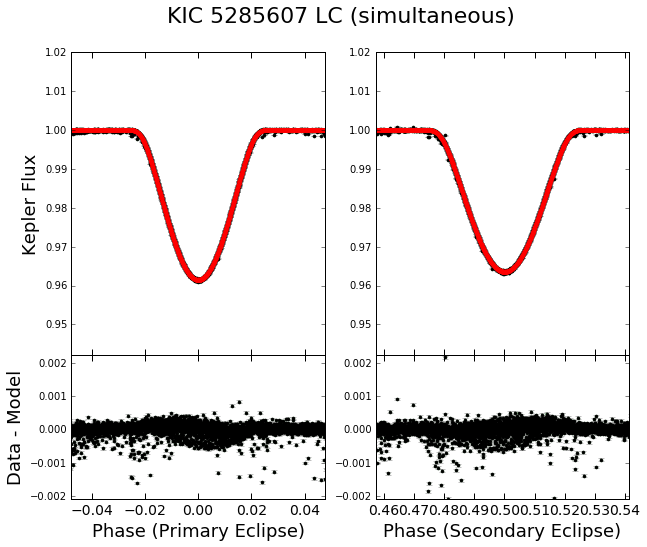

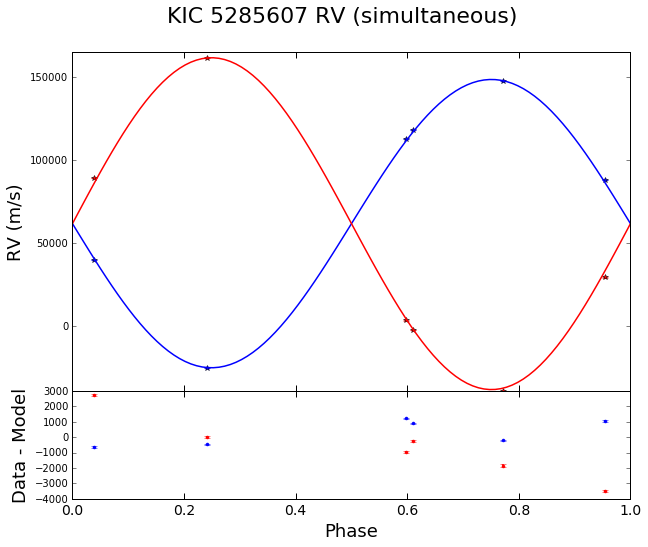

In [111]:
plt.rc('figure', titlesize=22)

def make_lcrv_plots(kic, allpars, prefix, suffix='', savefig=True, polyorder=2, ooe=True):
    residuals = lnlike_lcrv(allpars, qua=np.unique(keblat.quarter), polyorder=polyorder,
                            residual=True)
    lcpars = keblat.getpars(partype='lc')[:13]
    lcmod, lcpol = keblat.lcfit(lcpars, keblat.jd[keblat.clip], keblat.quarter[keblat.clip],
    				keblat.flux[keblat.clip], keblat.fluxerr[keblat.clip],
    				keblat.crowd[keblat.clip], polyorder=2, ooe=ooe)

    phase = ((keblat.jd[keblat.clip]-lcpars[4]) % lcpars[3])/lcpars[3]
    phase[phase<-np.clip(keblat.pwidth*3., 0., 0.2)]+=1.
    phase[phase>np.clip(keblat.sep+keblat.swidth*3., keblat.sep, 1.0)]-=1.

    lcres = keblat.flux[keblat.clip] - lcmod*lcpol

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(121)
    ax.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/lcpol, 'g.', alpha=0.4)
    ax.errorbar(phase, keblat.flux[keblat.clip]/lcpol,
                 keblat.fluxerr[keblat.clip], fmt='k.', ecolor='gray')
    ax.plot(phase, lcmod, 'r.')
    ax.set_xlim((-1.2*keblat.pwidth, 1.2*keblat.pwidth))
    ax.set_ylim((np.min(lcmod)*0.98, np.max(lcmod)*1.02))
    ax.set_ylabel('Kepler Flux')

    divider = make_axes_locatable(ax)
    axb = divider.append_axes("bottom", size=2.0, pad=0, sharex=ax)
    axb.plot(keblat.phase[keblat.clip], lcres, 'g.', alpha=0.4)
    axb.errorbar(phase, lcres,
                 np.sqrt(keblat.fluxerr[keblat.clip]**2 + keblat.pars['lcerr']**2), fmt='k.', ecolor='gray')

    axb.set_xlim((-1.2*keblat.pwidth, 1.2*keblat.pwidth))
    axb.set_ylim((np.min(lcres), np.max(lcres)))
    axb.set_ylabel('Data - Model')
    axb.set_xlabel('Phase (Primary Eclipse)')
    #axb.set_yticklabels(axb.yaxis.get_majorticklabels()[1:])

    ax2 = fig.add_subplot(122)
    ax2.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/lcpol, 'g.', alpha=0.4)
    ax2.errorbar(phase, keblat.flux[keblat.clip]/lcpol,
                 keblat.fluxerr[keblat.clip], fmt='k.', ecolor='gray')
    ax2.plot(phase, lcmod, 'r.')
    ax2.set_xlim((-1.2*keblat.swidth+keblat.sep, 1.2*keblat.swidth+keblat.sep))
    ax2.set_ylim((np.min(lcmod)*0.98, np.max(lcmod)*1.02))

    divider2 = make_axes_locatable(ax2)
    ax2b = divider2.append_axes("bottom", size=2.0, pad=0, sharex=ax2)
    ax2b.plot(keblat.phase[keblat.clip], lcres, 'g.', alpha=0.4)
    ax2b.errorbar(phase, lcres,
                 np.sqrt(keblat.fluxerr[keblat.clip]**2 + keblat.pars['lcerr']**2), fmt='k.', ecolor='gray')

    ax2b.set_xlim((-1.2*keblat.swidth+keblat.sep, 1.2*keblat.swidth+keblat.sep))
    ax2b.set_ylim((np.min(lcres), np.max(lcres)))
    ax2b.set_xlabel('Phase (Secondary Eclipse)')

    #ax2b.set_yticklabels(ax2b.yaxis.get_majorticklabels()[1:])


    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.suptitle('KIC '+str(kic)+' LC (simultaneous)')
    if savefig:
        plt.savefig(prefix+suffix+'_LC.png')

    # rvpars = keblat.getpars(partype='rv')
    rvpars = np.array([keblat.pars['msum'], keblat.pars['mrat'], keblat.pars['period'], keblat.pars['tpe'],
                       keblat.pars['esinw'], keblat.pars['ecosw'], keblat.pars['inc'], keblat.pars['k0'], keblat.pars['rverr']])

    rv_fit = keblat.rvfit(rvpars, keblat.rv_t)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    rvphase = (keblat.rv_t - keblat.pars['tpe'])%keblat.pars['period']/keblat.pars['period']
    ax.errorbar(rvphase[~keblat.bad1], keblat.rv1_obs[~keblat.bad1], keblat.rv1_err_obs[~keblat.bad1], fmt='b*')
    ax.errorbar(rvphase[~keblat.bad2], keblat.rv2_obs[~keblat.bad2], keblat.rv2_err_obs[~keblat.bad2], fmt='r*')
    rvt = np.linspace(0, 1, 100)*keblat.pars['period']+keblat.pars['tpe']
    rvmod = keblat.rvfit(rvpars, rvt)
    ax.plot(np.linspace(0, 1, 100), rvmod[0], 'b-')
    ax.plot(np.linspace(0, 1, 100), rvmod[1], 'r-')
    ax.set_ylabel('RV (m/s)')
    ax.set_ylim(min(np.nanmin(rvmod[0]), 
                    np.nanmin(rvmod[1]))-(0.02*abs(min(np.nanmin(rvmod[0]), 
                    np.nanmin(rvmod[1])))),
               max(np.nanmax(rvmod[0]), 
                    np.nanmax(rvmod[1]))+ (0.02*abs(max(np.nanmax(rvmod[0]), 
                    np.nanmax(rvmod[1])))))
    #ax.set_yticklabels(ax.yaxis.get_majorticklabels()[:-1])

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size=1.5, pad=0, sharex=ax)
    ax2.errorbar(rvphase[~keblat.bad1], (keblat.rv1_obs-rv_fit[0])[~keblat.bad1], np.sqrt(keblat.rv1_err_obs**2+rvpars[-1]**2)[~keblat.bad1], fmt='b.')
    ax2.errorbar(rvphase[~keblat.bad2], (keblat.rv2_obs-rv_fit[1])[~keblat.bad2], np.sqrt(keblat.rv2_err_obs**2+rvpars[-1]**2)[~keblat.bad2], fmt='r.')

    ax2.set_xlabel('Phase')
    ax2.set_ylabel('Data - Model')
    #ax2.set_yticklabels(ax2.yaxis.get_majorticklabels()[:-1])
    plt.setp(ax.get_xticklabels(), visible=False)
    #plt.setp(ax2.get_yticklabels()[-1], visible=False)

    plt.suptitle('KIC '+str(kic)+' RV (simultaneous)')
    if savefig:
        plt.savefig(prefix+suffix+'_RV.png')

    return True

make_lcrv_plots(kic, opt_lcrvpars, prefix, suffix='lcrv', savefig=True, polyorder=2)
#keblat.plot_lcrv(opt_lcrvpars, prefix, savefig=True)
#np.savetxt(prefix+'lcrv.lmfit', opt_lcrvpars)

In [101]:
keblat.pars

OrderedDict([('m1', 1.4989942419494748),
             ('m2', 1.3010056555340253),
             ('z0', None),
             ('age', None),
             ('dist', None),
             ('ebv', None),
             ('h0', None),
             ('period', 3.8994010811047519),
             ('tpe', 126.57750421214521),
             ('esinw', 0.0028535991077701661),
             ('ecosw', 0.0001266346710499533),
             ('b', 1.2574264941724962),
             ('q1', 0.35600086443005352),
             ('q2', 0.00013930634736453174),
             ('q3', 0.28330148733434801),
             ('q4', 0.44946004867307754),
             ('lcerr', 0.0),
             ('isoerr', None),
             ('k0', 61831.177272469875),
             ('rverr', 0.0),
             ('msum', 2.7999998974835001),
             ('mrat', 0.86791904806921671),
             ('rsum', 3.5054356726937939),
             ('rrat', 0.55461831835636666),
             ('r1', 2.2548529316185757),
             ('r2', 1.2505827410752179),
 

In [113]:
keblat.lnlike_lcrv?

In [116]:
bounds = np.array([keblat.parbounds[ii] for ii in ['msum', 'mrat', 'rsum', 
                   'rrat', 'period', 'tpe', 'esinw', 'b', 'frat', 
                       'q1', 'q2', 'q3', 'q4', 'lcerr', 'k0', 'rverr']])
print bounds[:,0]

[  2.50000000e+00   8.00000000e-01   1.00000000e-01   1.00000000e-05
   3.82141308e+00   1.24045954e+02  -9.90000000e-01   0.00000000e+00
   1.00000000e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -3.92122600e+04   0.00000000e+00]
